# Import Libraries

In [1]:
import os
import pandas as pd
import glob
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import torch
import gc
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import confusion_matrix

from misl_dataset import train_valid_test_split

In [2]:
device = torch.device('cpu')
gc.collect()

0

## Extracting the Patches from the WSI

## VGG-16 Feature Extraction

The WSI images are too large to handle. So, we included the extracted patches to make everything run better and faster.

In [8]:
!python ./vgg16_feature_extraction_test.py

TCGA-A7-A0CE-01A
17
/Users/kasraborazjani/opt/miniconda3/envs/mmfl/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/kasraborazjani/opt/miniconda3/envs/mmfl/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
torch.Size([17, 1000])
.DS_Store
TCGA-D8-A27I-01A
36
torch.Size([36, 1000])
TCGA-4H-AAAK-01A
20
torch.Size([20, 1000])
TCGA-BH-A0HW-01A
25
torch.Size([25, 1000])
These patients were not processed: ['.DS_Store']
These patients were processed: ['TCGA-A7-A0CE-01A', 'TCGA-D8-A27I-01A', 'TCGA-4H

## K-Means Clustering

In [6]:
def K_means_clustering(feature, k):
    feature = np.array(feature)
    kmeans = KMeans(n_clusters = k, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(feature)
    with open("Existing_model.pkl", "wb") as f:
        pickle.dump(kmeans, f)
    cluster_assignments = kmeans.labels_
    centroid = kmeans.cluster_centers_
     
    # Calculating the sum of the intra-cluster distances
    inertia = kmeans.inertia_
    return cluster_assignments, inertia, centroid

vgg_features = []
pid = []
# patient_path = '../data/test_images/'
patient_path = 'C:/Users/RaghulKrish/Desktop/UB/Spring_23/CVIP/Project/CSE573-Final-Project/data/test_images/'
patient_list =  os.listdir(patient_path)
if '.DS_Store' in patient_list:
    patient_list.pop(patient_list.index('.DS_Store'))
for name in patient_list:
    df = pd.read_csv(os.path.join(patient_path, name))
    name = name.lower()
    pid.append([name[:12]] * len(df))
    vgg_features.append(df)
vgg_features = pd.concat(vgg_features, ignore_index = True)
pid = sum(pid, [])

vgg_features = vgg_features.drop(columns = "Unnamed: 0")

if os.path.exists("./Existing_model.pkl"):
    with open("Existing_model.pkl", "rb") as f:
        existing_model = pickle.load(f)
    
    cluster_assign = existing_model.predict(vgg_features)
    
else:
    cluster_assign, performance, centroid = K_means_clustering(feature = vgg_features, k = 10)

print(cluster_assign.shape)

c:\Users\RaghulKrish\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


(4152,)


In [7]:
vgg_features['cluster_num'] = cluster_assign
vgg_features['pid'] = pid

vgg_features.to_csv('clustered_data_test.csv', index = False)

## Classifier

Constants

In [8]:
epochs = 30
batch_size = 1
lr = 0.001
num_clusters = 10

# Model Definition

In [9]:
import torch.nn as nn
import torch

class DeepAttnMIL_Surv(nn.Module):
    """
    Deep AttnMISL Model definition
    """
    def __init__(self, cluster_num):
        super(DeepAttnMIL_Surv, self).__init__()
        self.embedding_net = nn.Sequential(nn.Conv1d(1000, 64, 1),
                                     nn.ReLU(),
                                     nn.AdaptiveAvgPool1d(1)
                                     )

        self.attention = nn.Sequential(
            nn.Linear(64, 32), # V
            nn.Tanh(),
            nn.Linear(32, 1)  # W
        )

        self.fc6 = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(32,2)
        )
        self.cluster_num = cluster_num

    def masked_softmax(self, x, mask=None):
        """
        Performs masked softmax, as simply masking post-softmax can be
        inaccurate
        :param x: [batch_size, num_items]
        :param mask: [batch_size, num_items]
        :return:
        """
        if mask is not None:
            mask = mask.float()
        if mask is not None:
            x_masked = x * mask + (1 - 1 / (mask+1e-5))
        else:
            x_masked = x
        x_max = x_masked.max(1)[0]
        x_exp = (x - x_max.unsqueeze(-1)).exp()
        if mask is not None:
            x_exp = x_exp * mask.float()
        return x_exp / x_exp.sum(1).unsqueeze(-1)

    def forward(self, x, mask):

        " x is a tensor list"
        res = []
        for i in range(self.cluster_num):
                
            hh = x[i]
            
            hh = hh.unsqueeze(0).reshape(1, 1000, len(hh))
            
            output = self.embedding_net(hh)
            
            output = output.view(output.size()[0], -1)
            
            res.append(output)

        h = torch.cat(res)

        b = h.size(0)
        c = h.size(1)

        h = h.view(b, c)
        
        A = self.attention(h)
        A = torch.transpose(A, 1, 0)  # KxN
        
        A = self.masked_softmax(A, mask)

        M = torch.mm(A, h)  # KxL

        Y_pred = self.fc6(M)

        return Y_pred

# Loading Dataset

In [22]:
data_path = './clustered_data_test.csv'
label_path = './BRCA_stages.csv'

test_dataset = train_valid_test_split(data_path, label_path, test_mode=True)

<built-in function len>


Evaluating the Test Dataset

In [23]:
# create a new instance of your model
model_test = DeepAttnMIL_Surv(num_clusters).to(device)

# load the best_model weights into the new instance
model_test.load_state_dict(torch.load('best_model.pt'))

# set the model to evaluation mode
model_test.eval()

def accuracy(y_pred, labels):
    return np.sum(y_pred == labels.numpy()) / labels.shape[0] * 100

def test_predict(batch, label):
    patient, mask = batch
    criterion = nn.CrossEntropyLoss()
    for cluster_id in range(len(patient)):
        patient[cluster_id] = patient[cluster_id].to(device)
    mask = mask.to(device)
    label = label.to(device)

    output = model_test(patient, mask)
    label.unsqueeze_(0)
    loss = criterion(output, label)
    output = output.to("cpu")
    y_pred = np.argmax(np.array(output), axis = 1)
    label = label.to("cpu")
    label = np.argmax(label, axis = 1)
    acc = accuracy(y_pred, label) 
    return {'loss': loss, 'acc': acc, 'pred': y_pred, 'true': label}

with torch.no_grad():
    test_op = [test_predict(batch, label) for batch_idx, (batch, label) in enumerate(test_dataset)]
    batch_losses = [x['loss'] for x in test_op]
    test_loss = torch.stack(batch_losses).mean()
    batch_accs = [x['acc'] for x in test_op]
    test_acc = (np.array(batch_accs)).mean()

print(f'Test Loss: {test_loss}, Test Accuracy: {test_acc}')

Test Loss: 0.04760957881808281, Test Accuracy: 100.0


## Training the Entire Dataset

### VGG-16 Feature Extraction

In [ ]:
!python vgg16_feature_extraction_train.py

### K-Means Clustering

In [11]:
def K_means_clustering(feature, k):
    feature = np.array(feature)
    kmeans = KMeans(n_clusters = k, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(feature)
    with open("Existing_model.pkl", "wb") as f:
        pickle.dump(kmeans, f)
    cluster_assignments = kmeans.labels_
    centroid = kmeans.cluster_centers_
     
    # Calculating the sum of the intra-cluster distances
    inertia = kmeans.inertia_
    return cluster_assignments, inertia, centroid

vgg_features = []
pid = []
# patient_path = '../data/train_images/'
patient_path = 'C:/Users/RaghulKrish/Desktop/UB/Spring_23/CVIP/Project/CSE573-Final-Project/data/train_images/'
patient_list =  os.listdir(patient_path)
if '.DS_Store' in patient_list:
    patient_list.pop(patient_list.index('.DS_Store'))
for name in patient_list:
    df = pd.read_csv(os.path.join(patient_path, name))
    name = name.lower()
    pid.append([name[:12]] * len(df))
    vgg_features.append(df)
vgg_features = pd.concat(vgg_features, ignore_index = True)
pid = sum(pid, [])

vgg_features = vgg_features.drop(columns = "Unnamed: 0")

if os.path.exists("./Existing_model.pkl"):
    with open("Existing_model.pkl", "rb") as f:
        existing_model = pickle.load(f)
    
    cluster_assign = existing_model.predict(vgg_features)
    
else:
    cluster_assign, performance, centroid = K_means_clustering(feature = vgg_features, k = 10)

print(cluster_assign.shape)

Ex


c:\Users\RaghulKrish\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


(78896,)


In [12]:
vgg_features['cluster_num'] = cluster_assign
vgg_features['pid'] = pid

vgg_features.to_csv('clustered_data_train.csv', index = False)

Loading Train Dataset

In [13]:
data_path = './clustered_data_train.csv'
label_path = './BRCA_stages.csv'

train_data, valid_data, test_data = train_valid_test_split(data_path, label_path, 0.2, 0.2)

<built-in function len>
test stage values: stage ii    10
stage i      3
Name: stage, dtype: int64
train stage values: stage ii    48
stage i     13
Name: stage, dtype: int64
validation stage values: stage ii    8
stage i     2
Name: stage, dtype: int64


c:\Users\RaghulKrish\Desktop\UB\Spring_23\CVIP\Project\CSE573-Final-Project\misl_dataset.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.labels['stage'] = self.labels.stage.map(lambda x: one_hot_binary(x))


In [15]:
model = DeepAttnMIL_Surv(cluster_num = num_clusters).to(device)

if os.path.exists('./best_model.pt'):
    model.load_state_dict(torch.load('best_model.pt'))
model.train()

train_loss = []
loss_valid = []
acc_val = []
acc_train = []
best_loss = float('inf')
patience = 7

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = lr, weight_decay = 0.005, momentum = 0.9)

def predict(batch, label):
    patient, mask = batch
    for cluster_id in range(len(patient)):
        patient[cluster_id] = patient[cluster_id].to(device)
    mask = mask.to(device)
    label = label.to(device)

    output = model(patient, mask)
    label.unsqueeze_(0)
    loss = criterion(output, label)
    output = output.to("cpu")
    y_pred = np.argmax(np.array(output), axis = 1)
    label = label.to("cpu")
    label = np.argmax(label, axis = 1)
    acc = accuracy(y_pred, label) 
    return {'loss': loss, 'acc': acc}

def accuracy(y_pred, labels):
    return np.sum(y_pred == labels.numpy()) / labels.shape[0] * 100

for i in range(epochs):
    epoch_loss = []
    for batch_idx, (batch, label) in enumerate(train_data):
        patient, mask = batch
        for cluster_id in range(len(patient)):
            patient[cluster_id] = patient[cluster_id].to(device)
        label = label.to(device)
        mask = mask.to(device)

        output = model(patient, mask)

        label.unsqueeze_(0)
        loss = criterion(output, label)
        epoch_loss.append(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = torch.stack(epoch_loss)
    epoch_loss = epoch_loss.to("cpu").detach().numpy().mean()
    train_loss.append(epoch_loss)

    if i % 10 == 0:
        print(f'Epoch: {i} ---> Epoch Loss: {epoch_loss}')

    with torch.no_grad():
        train_op = [predict(batch, label) for batch_idx, (batch, label) in enumerate(train_data)]
        train_acc = [x['acc'] for x in train_op]
        acc_train.append((np.array(train_acc)).mean())
        
        valid_op = [predict(batch, label) for batch_idx, (batch, label) in enumerate(valid_data)]
        batch_losses = [x['loss'] for x in valid_op]
        valid_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['acc'] for x in valid_op]
        valid_acc = (np.array(batch_accs)).mean()
        acc_val.append(valid_acc)
        loss_valid.append(valid_loss)
        if i % 10 == 0:
            print(f"epoch: {i}, Validation loss: {valid_loss}, Validation Accuracy: {valid_acc}%")
    
    # Performing Early stopping
    if valid_loss < best_loss:
        best_loss = valid_loss
        best_model = model.state_dict()
        torch.save(best_model, 'best_model.pt')
        early_stop_count = 0
    else:
        early_stop_count += 1
        if early_stop_count >= patience:
            print(f"Validation loss hasn't improved in {patience} epochs. Stopping early!!!")
            break

Epoch: 0 ---> Epoch Loss: 0.6145861744880676
epoch: 0, Validation loss: 0.5789944529533386, Validation Accuracy: 80.0%
Epoch: 10 ---> Epoch Loss: 0.3478543758392334
epoch: 10, Validation loss: 0.2756676971912384, Validation Accuracy: 80.0%
Epoch: 20 ---> Epoch Loss: 0.08918686211109161
epoch: 20, Validation loss: 0.11816076934337616, Validation Accuracy: 100.0%
Validation loss hasn't improved in 7 epochs. Stopping early!!!


Testing the Model

In [16]:

# create a new instance of your model
model_test = DeepAttnMIL_Surv(num_clusters).to(device)

# load the best_model weights into the new instance
model_test.load_state_dict(best_model)

# set the model to evaluation mode
model_test.eval()

def test_predict(batch, label):
    patient, mask = batch
    for cluster_id in range(len(patient)):
        patient[cluster_id] = patient[cluster_id].to(device)
    mask = mask.to(device)
    label = label.to(device)

    output = model_test(patient, mask)
    label.unsqueeze_(0)
    loss = criterion(output, label)
    output = output.to("cpu")
    y_pred = np.argmax(np.array(output), axis = 1)
    label = label.to("cpu")
    label = np.argmax(label, axis = 1)
    acc = accuracy(y_pred, label) 
    return {'loss': loss, 'acc': acc, 'pred': y_pred, 'true': label}

with torch.no_grad():
    test_op = [test_predict(batch, label) for batch_idx, (batch, label) in enumerate(test_data)]
    batch_losses = [x['loss'] for x in test_op]
    test_loss = torch.stack(batch_losses).mean()
    batch_accs = [x['acc'] for x in test_op]
    test_acc = (np.array(batch_accs)).mean()

print(f'Test Loss: {test_loss}, Test Accuracy: {test_acc}')

Test Loss: 0.09858594834804535, Test Accuracy: 92.3076923076923


Plotting Loss

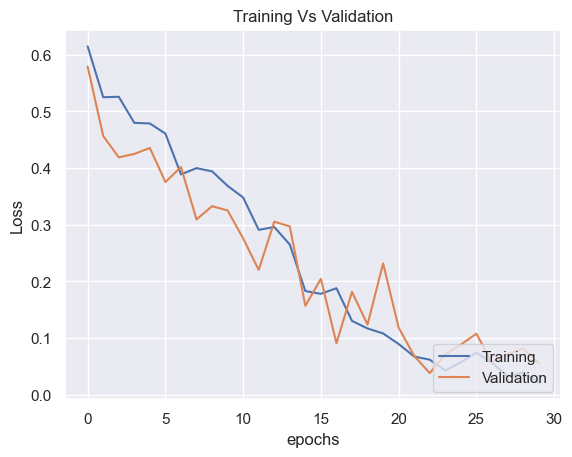

In [17]:
sns.set(style = "darkgrid") # Background Theme

plt.plot(train_loss)
# loss_valid = torch.stack(loss_valid)
# loss_valid = loss_valid.to('cpu')
plt.plot(loss_valid)
plt.legend(["Training", "Validation"], loc ="lower right")
plt.xlabel("epochs")
plt.title("Training Vs Validation")
plt.ylabel("Loss")
plt.savefig('./train_val_loss.png')

Plotting Accuracy

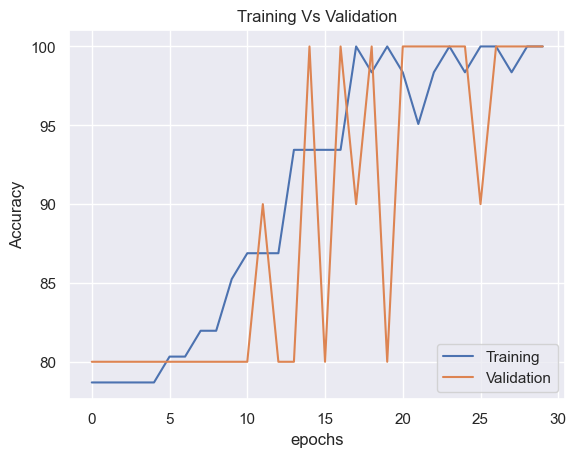

In [18]:
plt.plot(acc_train)
plt.plot(acc_val)
plt.legend(["Training", "Validation"], loc ="lower right")
plt.xlabel("epochs")
plt.title("Training Vs Validation")
plt.ylabel("Accuracy")
plt.savefig('train_val_acc.png')

Confusion Matrix

In [19]:
pred = np.array([x['pred'] for x in test_op])
true = np.stack([x['true'] for x in test_op])

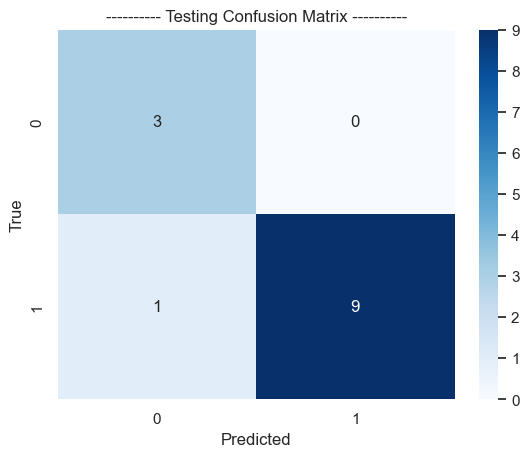

In [20]:
cm = confusion_matrix(true, pred)
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("---------- Testing Confusion Matrix ----------")
# plt.show()
plt.savefig('./conf_mat.png')

In [21]:
from sklearn.metrics import f1_score, recall_score, precision_score

print("F1 score: {}".format(f1_score(true, pred)))
print("Recall: {}".format(recall_score(true, pred)))
print("Precision score: {}".format(precision_score(true, pred)))

F1 score: 0.9473684210526316
Recall: 0.9
Precision score: 1.0
